# **Disclaimer:**  
> The dataset presented in this project has been **simulated** to protect proprietary or confidential company information.  
> While the data values do not correspond to real project information, the structure, methodology, and analytical approach are consistent with the original real-world project.  
> The insights and findings reflect the actual outcomes of the real project, with only the underlying data replaced.a.

### Purpose & Process
The goal of this analysis is to understand the severity of a change order (change value as a percentage of the original contract value) to support budgeting, procurement, and risk management decisions.

#### Process followed:

Data Collection & Preparation: Imported historical change orders, project characteristics, and the inital contract value.

Exploratory Analysis: Visualized response variable, change order breakdown by company, and reviewed statistical characterics of quanitative variables.

Modeling Approach: Applied OLS to build linear models and used residual plots and qqplots to analyze conditional volatility and persistence.

Evaluation & Interpretation: Assessed model fit, variable performance and OLS assumptions; compared behavior across two models.

Findings & Recommendations: Summarized key insights and proposed next steps for risk management and further model improvement.

In [3]:
# Importing required libraries for data manipulation, modeling, or visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.formula.api import rlm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [4]:
# Reading in CSV files containing commitments vs actuals, and change orders data. 
change_order = pd.read_csv("change orders.csv")
c_vs_a = pd.read_csv("Commitments vs actuals.csv")
c_vs_a = c_vs_a.drop_duplicates()


In [5]:
# Confirming no missing data
change_order.isna().sum()

ProjectName     0
Status          0
CompanyName     0
Amount          0
ReasonCode      0
Project Name    0
FundingType     0
dtype: int64

In [6]:
# Viewing Data Frame for layout and formatting
c_vs_a

,ProjectName,CompanyName,OriginalCommitmentValue,ProjectName.1,ActualsPaid,FundingType,ImpactsSpaceInventoryY/N,ProjectCategory,Projecttype,CommitmentType
0,Alpharetta Asphalt & Concrete overlay,KP,5077.067512,Alpharetta Asphalt & Concrete overlay,5705.556144,Plant Maint and Renovation (PMR),N,NaN,CPBLI,NaN
1,Alpharetta Asphalt & Concrete overlay,KC CONSTRUCTION OF GEORGIA INC - 100194403,359223.875650,Alpharetta Asphalt & Concrete overlay,355971.898150,Plant Maint and Renovation (PMR),N,NaN,CPBLI,zLegacy - Pay Application
2,Alpharetta Asphalt & Concrete overlay,KP,-5449.372826,Alpharetta Asphalt & Concrete overlay,-5160.693040,Plant Maint and Renovation (PMR),N,NaN,CPBLI,NaN
3,Alpharetta Asphalt & Concrete overlay,KP,-77837.650017,Alpharetta Asphalt & Concrete overlay,-80531.911979,Plant Maint and Renovation (PMR),N,NaN,CPBLI,NaN
4,Alpharetta Asphalt & Concrete overlay,KP,4000.237039,Alpharetta Asphalt & Concrete overlay,4032.043007,Plant Maint and Renovation (PMR),N,NaN,CPBLI,NaN
...,...,...,...,...,...,...,...,...,...,...
19566,West Cobb Security,ROSE INTERNATIONAL INC - 100024498,1445.289100,West Cobb Security,1402.433938,Plant Maint and Renovation (PMR),N,NaN,CPBLI,NaN
19567,West Cobb Security,ROSE INTERNATIONAL INC - 100024498,517.002933,West Cobb Security,454.476752,Plant Maint and Renovation (PMR),N,NaN,CPBLI,NaN
19568,West Cobb Security,KP,282.297246,West Cobb Security,313.987722,Plant Maint and Renovation (PMR),N,NaN,CPBLI,NaN
19569,West Cobb Security,KP,1942.203281,West Cobb Security,1925.737302,Plant Maint and Renovation (PMR),N,NaN,CPBLI,NaN


In [7]:
# Checking number of change orders per company
change_order["CompanyName"].value_counts()

CompanyName
LEAPLEY CONSTRUCTION GROUP OF ATLANTA - 100109456    155
MCCARTHY BUILDING COMPANIES INC - 100013473           26
CARROLL DANIEL CONSTRUCTION CO - 100200909            24
GRESHAM SMITH - 100065499                             23
WEBMYERS CONSTRUCTION LLC - 100150242                 10
GUIDEPOST SOLUTIONS LLC - 100042226                    9
EPSTEN GROUP INC - 100152259                           6
KC CONSTRUCTION OF GEORGIA INC - 100194403             5
YANCEY BROS CO - 100092368                             4
MAZZETTI INC - 100021203                               4
HDR ARCHITECTURE  INC - 100050631                      4
TELECOM INNOVATIONS LLC - 100130575                    3
MIKES PAINTING & HOME IMPROVEMENT INC - 100113741      2
DG INVESTMENT INTERMEDIATE HOLDINGS 2 - 100021530      2
SOUTHEASTERN COMMERCIAL FLOORING INC - 100092358       2
TLS ELECTRICAL CO INC - 100022743                      2
KONE INC - 100019518                                   2
CUMMING MANAGEMENT 

In [8]:
# Selecting contractors we use the most often to minimize outlairs and reflect more expected results on a project
# Selecting Reason Codes that are more applicable for projects on a daily manner
change_order = change_order[change_order["ReasonCode"].isin(["Administrative Chg.","Owner Change Request","Design Standards Chg","Unforeseen Condition"])]
c_vs_a = c_vs_a[c_vs_a["CompanyName"].isin(["KC CONSTRUCTION OF GEORGIA INC - 100194403","LEAPLEY CONSTRUCTION GROUP OF ATLANTA - 100109456","WEBMYERS CONSTRUCTION LLC - 100150242", "CARROLL DANIEL CONSTRUCTION CO - 100200909", "MCCARTHY BUILDING COMPANIES INC - 100013473", "GRESHAM SMITH - 100065499", ""])]

In [9]:
# Viewing Data Frame for layout and formatting
c_vs_a.head()

,ProjectName,CompanyName,OriginalCommitmentValue,ProjectName.1,ActualsPaid,FundingType,ImpactsSpaceInventoryY/N,ProjectCategory,Projecttype,CommitmentType
1,Alpharetta Asphalt & Concrete overlay,KC CONSTRUCTION OF GEORGIA INC - 100194403,359223.875650,Alpharetta Asphalt & Concrete overlay,355971.898150,Plant Maint and Renovation (PMR),N,NaN,CPBLI,zLegacy - Pay Application
19,Alpharetta Asphalt & Concrete overlay,KC CONSTRUCTION OF GEORGIA INC - 100194403,315761.165256,Alpharetta Asphalt & Concrete overlay,349702.120127,Plant Maint and Renovation (PMR),N,NaN,CPBLI,zLegacy - Pay Application
21,Alpharetta Elevator,LEAPLEY CONSTRUCTION GROUP OF ATLANTA - 100109456,482828.859874,Alpharetta Elevator,506268.757947,Plant Maint and Renovation (PMR),N,NaN,CPBLI,Construction - General Contractor - GC
23,Alpharetta Elevator,LEAPLEY CONSTRUCTION GROUP OF ATLANTA - 100109456,506438.851113,Alpharetta Elevator,523168.145974,Plant Maint and Renovation (PMR),N,NaN,CPBLI,Construction - General Contractor - GC
24,Alpharetta Elevator,LEAPLEY CONSTRUCTION GROUP OF ATLANTA - 100109456,515774.714184,Alpharetta Elevator,539839.811209,Plant Maint and Renovation (PMR),N,NaN,CPBLI,Construction - General Contractor - GC


In [10]:
# Viewing Data Frame for layout and formatting
c_vs_a.drop_duplicates()

,ProjectName,CompanyName,OriginalCommitmentValue,ProjectName.1,ActualsPaid,FundingType,ImpactsSpaceInventoryY/N,ProjectCategory,Projecttype,CommitmentType
1,Alpharetta Asphalt & Concrete overlay,KC CONSTRUCTION OF GEORGIA INC - 100194403,359223.875650,Alpharetta Asphalt & Concrete overlay,355971.898150,Plant Maint and Renovation (PMR),N,NaN,CPBLI,zLegacy - Pay Application
19,Alpharetta Asphalt & Concrete overlay,KC CONSTRUCTION OF GEORGIA INC - 100194403,315761.165256,Alpharetta Asphalt & Concrete overlay,349702.120127,Plant Maint and Renovation (PMR),N,NaN,CPBLI,zLegacy - Pay Application
21,Alpharetta Elevator,LEAPLEY CONSTRUCTION GROUP OF ATLANTA - 100109456,482828.859874,Alpharetta Elevator,506268.757947,Plant Maint and Renovation (PMR),N,NaN,CPBLI,Construction - General Contractor - GC
23,Alpharetta Elevator,LEAPLEY CONSTRUCTION GROUP OF ATLANTA - 100109456,506438.851113,Alpharetta Elevator,523168.145974,Plant Maint and Renovation (PMR),N,NaN,CPBLI,Construction - General Contractor - GC
24,Alpharetta Elevator,LEAPLEY CONSTRUCTION GROUP OF ATLANTA - 100109456,515774.714184,Alpharetta Elevator,539839.811209,Plant Maint and Renovation (PMR),N,NaN,CPBLI,Construction - General Contractor - GC
...,...,...,...,...,...,...,...,...,...,...
19276,TownPark Security,LEAPLEY CONSTRUCTION GROUP OF ATLANTA - 100109456,863970.523695,TownPark Security,755382.867959,Plant Maint and Renovation (PMR),N,NaN,CPBLI,Construction - General Contractor - GC
19559,West Cobb Security,CARROLL DANIEL CONSTRUCTION CO - 100200909,142611.776437,West Cobb Security,141791.658477,Plant Maint and Renovation (PMR),N,NaN,CPBLI,Construction - General Contractor - GC
19560,West Cobb Security,CARROLL DANIEL CONSTRUCTION CO - 100200909,143005.683074,West Cobb Security,158988.085491,Plant Maint and Renovation (PMR),N,NaN,CPBLI,Construction - General Contractor - GC
19561,West Cobb Security,CARROLL DANIEL CONSTRUCTION CO - 100200909,136146.187492,West Cobb Security,149278.786122,Plant Maint and Renovation (PMR),N,NaN,CPBLI,Construction - General Contractor - GC


In [11]:
# Viewing Data Frame for layout and formatting
change_order

,ProjectName,Status,CompanyName,Amount,ReasonCode,Project Name,FundingType
0,Alpharetta Asphalt & Concrete overlay,Approved,KC CONSTRUCTION OF GEORGIA INC - 100194403,"3,215.75",Owner Change Request,Alpharetta Asphalt & Concrete overlay,Plant Maint and Renovation (PMR)
1,Alpharetta Elevator,Approved,LEAPLEY CONSTRUCTION GROUP OF ATLANTA - 100109456,"23,646.30",Design Standards Chg,Alpharetta Elevator,Plant Maint and Renovation (PMR)
2,Alpharetta Elevator,Approved,LEAPLEY CONSTRUCTION GROUP OF ATLANTA - 100109456,"1,885.90",Design Standards Chg,Alpharetta Elevator,Plant Maint and Renovation (PMR)
3,Alpharetta Security,Approved,CARROLL DANIEL CONSTRUCTION CO - 100200909,"2,459.35",Owner Change Request,Alpharetta Security,Plant Maint and Renovation (PMR)
4,Alpharetta Security,Approved,CARROLL DANIEL CONSTRUCTION CO - 100200909,"7,674.62",Owner Change Request,Alpharetta Security,Plant Maint and Renovation (PMR)
...,...,...,...,...,...,...,...
281,TownPark Security,Approved,LEAPLEY CONSTRUCTION GROUP OF ATLANTA - 100109456,"25,169.35",Owner Change Request,TownPark Security,Plant Maint and Renovation (PMR)
282,TownPark Security,Approved,LEAPLEY CONSTRUCTION GROUP OF ATLANTA - 100109456,"2,066.78",Design Standards Chg,TownPark Security,Plant Maint and Renovation (PMR)
283,TownPark UST Control Board,Approved,YANCEY BROS CO - 100092368,0.00,Administrative Chg.,TownPark UST Control Board,Plant Maint and Renovation (PMR)
284,TownPark UST Control Board,Approved,YANCEY BROS CO - 100092368,"2,316.20",Unforeseen Condition,TownPark UST Control Board,Plant Maint and Renovation (PMR)


In [12]:
# Viewing Data Frame for layout and formatting
c_vs_a

,ProjectName,CompanyName,OriginalCommitmentValue,ProjectName.1,ActualsPaid,FundingType,ImpactsSpaceInventoryY/N,ProjectCategory,Projecttype,CommitmentType
1,Alpharetta Asphalt & Concrete overlay,KC CONSTRUCTION OF GEORGIA INC - 100194403,359223.875650,Alpharetta Asphalt & Concrete overlay,355971.898150,Plant Maint and Renovation (PMR),N,NaN,CPBLI,zLegacy - Pay Application
19,Alpharetta Asphalt & Concrete overlay,KC CONSTRUCTION OF GEORGIA INC - 100194403,315761.165256,Alpharetta Asphalt & Concrete overlay,349702.120127,Plant Maint and Renovation (PMR),N,NaN,CPBLI,zLegacy - Pay Application
21,Alpharetta Elevator,LEAPLEY CONSTRUCTION GROUP OF ATLANTA - 100109456,482828.859874,Alpharetta Elevator,506268.757947,Plant Maint and Renovation (PMR),N,NaN,CPBLI,Construction - General Contractor - GC
23,Alpharetta Elevator,LEAPLEY CONSTRUCTION GROUP OF ATLANTA - 100109456,506438.851113,Alpharetta Elevator,523168.145974,Plant Maint and Renovation (PMR),N,NaN,CPBLI,Construction - General Contractor - GC
24,Alpharetta Elevator,LEAPLEY CONSTRUCTION GROUP OF ATLANTA - 100109456,515774.714184,Alpharetta Elevator,539839.811209,Plant Maint and Renovation (PMR),N,NaN,CPBLI,Construction - General Contractor - GC
...,...,...,...,...,...,...,...,...,...,...
19276,TownPark Security,LEAPLEY CONSTRUCTION GROUP OF ATLANTA - 100109456,863970.523695,TownPark Security,755382.867959,Plant Maint and Renovation (PMR),N,NaN,CPBLI,Construction - General Contractor - GC
19559,West Cobb Security,CARROLL DANIEL CONSTRUCTION CO - 100200909,142611.776437,West Cobb Security,141791.658477,Plant Maint and Renovation (PMR),N,NaN,CPBLI,Construction - General Contractor - GC
19560,West Cobb Security,CARROLL DANIEL CONSTRUCTION CO - 100200909,143005.683074,West Cobb Security,158988.085491,Plant Maint and Renovation (PMR),N,NaN,CPBLI,Construction - General Contractor - GC
19561,West Cobb Security,CARROLL DANIEL CONSTRUCTION CO - 100200909,136146.187492,West Cobb Security,149278.786122,Plant Maint and Renovation (PMR),N,NaN,CPBLI,Construction - General Contractor - GC


In [13]:
# Merging change_order and c_vs_a for final propcessing and modeling
merged_clean = pd.merge(change_order, c_vs_a, on=["CompanyName", "ProjectName"], how ="inner")

In [14]:
# Confirming all vairables used for modeling have no missing values, ProjectCategory will not be used and is not a concern
merged_clean.isna().sum()

ProjectName                    0
Status                         0
CompanyName                    0
Amount                         0
ReasonCode                     0
Project Name                   0
FundingType_x                  0
OriginalCommitmentValue        0
ProjectName.1                  0
ActualsPaid                    0
FundingType_y                  0
ImpactsSpaceInventoryY/N       0
ProjectCategory             2570
Projecttype                    0
CommitmentType                 0
dtype: int64

In [15]:
# Confirming all vairables are objects and need to be converted to the right format
merged_clean.dtypes

ProjectName                  object
Status                       object
CompanyName                  object
Amount                       object
ReasonCode                   object
Project Name                 object
FundingType_x                object
OriginalCommitmentValue     float64
ProjectName.1                object
ActualsPaid                 float64
FundingType_y                object
ImpactsSpaceInventoryY/N     object
ProjectCategory              object
Projecttype                  object
CommitmentType               object
dtype: object

In [16]:
# Selecting vairables I will use for further modeling
CO_data = merged_clean[["CompanyName", "ReasonCode", "Amount", "OriginalCommitmentValue"]].copy()

In [17]:
# Dropping duplicates in final data set
merged_clean=merged_clean.drop_duplicates()

In [18]:
# General code execution
CO_data

,CompanyName,ReasonCode,Amount,OriginalCommitmentValue
0,KC CONSTRUCTION OF GEORGIA INC - 100194403,Owner Change Request,"3,215.75",359223.875650
1,KC CONSTRUCTION OF GEORGIA INC - 100194403,Owner Change Request,"3,215.75",315761.165256
2,LEAPLEY CONSTRUCTION GROUP OF ATLANTA - 100109456,Design Standards Chg,"23,646.30",482828.859874
3,LEAPLEY CONSTRUCTION GROUP OF ATLANTA - 100109456,Design Standards Chg,"23,646.30",506438.851113
4,LEAPLEY CONSTRUCTION GROUP OF ATLANTA - 100109456,Design Standards Chg,"23,646.30",515774.714184
...,...,...,...,...
2692,LEAPLEY CONSTRUCTION GROUP OF ATLANTA - 100109456,Design Standards Chg,"2,066.78",863970.523695
2693,CARROLL DANIEL CONSTRUCTION CO - 100200909,Owner Change Request,"2,452.19",142611.776437
2694,CARROLL DANIEL CONSTRUCTION CO - 100200909,Owner Change Request,"2,452.19",143005.683074
2695,CARROLL DANIEL CONSTRUCTION CO - 100200909,Owner Change Request,"2,452.19",136146.187492


In [19]:
# Converting from object to string to address formatting items like commas, or to avoid errors when completing final conversion
# Data is set as correct type for each variable
CO_data["Amount"] = CO_data["Amount"].astype("string")
CO_data["OriginalCommitmentValue"] = CO_data["OriginalCommitmentValue"].astype("string")
CO_data["Amount"] = CO_data["Amount"].str.replace(",", "",regex=False) 
CO_data["OriginalCommitmentValue"] = CO_data["OriginalCommitmentValue"].str.replace(",","",regex=False)

CO_data["Amount"] = pd.to_numeric(CO_data["Amount"], errors = "coerce")
CO_data["OriginalCommitmentValue"] = pd.to_numeric(CO_data["OriginalCommitmentValue"], errors ="coerce")
CO_data["CompanyName"] = CO_data["CompanyName"].astype("category")
CO_data["ReasonCode"] = CO_data["ReasonCode"].astype("category")

In [20]:
# Confirming data types are corrected
CO_data.dtypes

CompanyName                category
ReasonCode                 category
Amount                      Float64
OriginalCommitmentValue     Float64
dtype: object

In [21]:
# Viewing Data Frame for layout and formatting
CO_data

,CompanyName,ReasonCode,Amount,OriginalCommitmentValue
0,KC CONSTRUCTION OF GEORGIA INC - 100194403,Owner Change Request,3215.75,359223.87565
1,KC CONSTRUCTION OF GEORGIA INC - 100194403,Owner Change Request,3215.75,315761.165256
2,LEAPLEY CONSTRUCTION GROUP OF ATLANTA - 100109456,Design Standards Chg,23646.3,482828.859874
3,LEAPLEY CONSTRUCTION GROUP OF ATLANTA - 100109456,Design Standards Chg,23646.3,506438.851113
4,LEAPLEY CONSTRUCTION GROUP OF ATLANTA - 100109456,Design Standards Chg,23646.3,515774.714184
...,...,...,...,...
2692,LEAPLEY CONSTRUCTION GROUP OF ATLANTA - 100109456,Design Standards Chg,2066.78,863970.523695
2693,CARROLL DANIEL CONSTRUCTION CO - 100200909,Owner Change Request,2452.19,142611.776437
2694,CARROLL DANIEL CONSTRUCTION CO - 100200909,Owner Change Request,2452.19,143005.683074
2695,CARROLL DANIEL CONSTRUCTION CO - 100200909,Owner Change Request,2452.19,136146.187492


In [22]:
# Creating variable that measures change as a percentage change based on inital commitment to identify severity
CO_data["changedeviation"] = CO_data["Amount"]/CO_data["OriginalCommitmentValue"]

In [23]:
# Identifying vendors with biggest mean change
CO_data.groupby("CompanyName", observed=False)["changedeviation"].mean()

CompanyName
CARROLL DANIEL CONSTRUCTION CO - 100200909           0.023312
GRESHAM SMITH - 100065499                            0.676262
KC CONSTRUCTION OF GEORGIA INC - 100194403            0.03955
LEAPLEY CONSTRUCTION GROUP OF ATLANTA - 100109456      0.0996
MCCARTHY BUILDING COMPANIES INC - 100013473           0.04531
WEBMYERS CONSTRUCTION LLC - 100150242                0.007016
Name: changedeviation, dtype: Float64

In [24]:
# Identifying number of change orders per company
CO_data.value_counts("CompanyName")

CompanyName
LEAPLEY CONSTRUCTION GROUP OF ATLANTA - 100109456    2042
GRESHAM SMITH - 100065499                             377
MCCARTHY BUILDING COMPANIES INC - 100013473           140
CARROLL DANIEL CONSTRUCTION CO - 100200909             83
WEBMYERS CONSTRUCTION LLC - 100150242                  37
KC CONSTRUCTION OF GEORGIA INC - 100194403             18
Name: count, dtype: int64

<Axes: xlabel='OriginalCommitmentValue'>

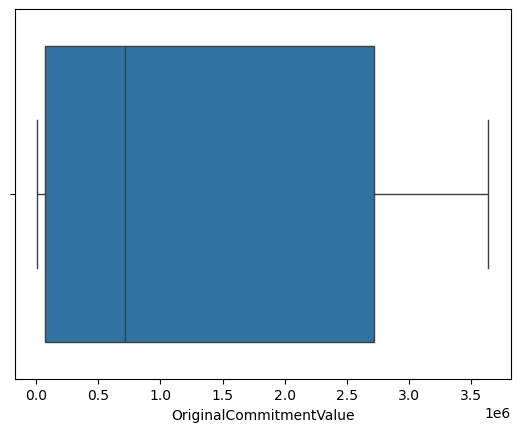

In [25]:
# Used a boxplot to examine the distribution of the data, revealing a strong right skew
sns.boxplot(x="OriginalCommitmentValue", data=CO_data)

<Axes: ylabel='changedeviation'>

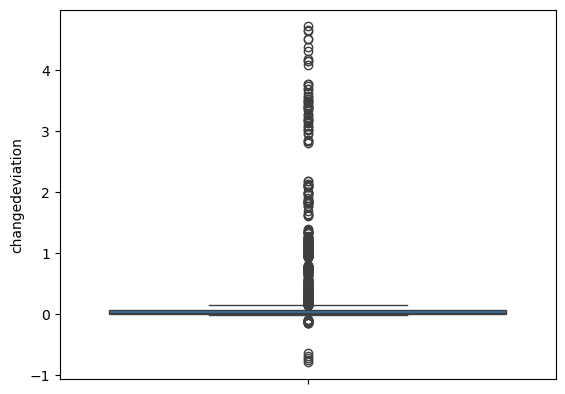

In [26]:
# Changed boxplot orientation to confirm significant outlairs in the data
sns.boxplot(y="changedeviation", data = CO_data)

In [27]:
# Found significant vairation in the values due to low sample size and large variation of project type and size
CO_data.describe()

,Amount,OriginalCommitmentValue,changedeviation
count,2697.0,2697.0,2697.0
mean,15643.375158,1494800.728,0.173372
std,38276.090083,1376798.202957,0.559677
min,-523807.87,9663.126992,-0.79949
25%,1694.92,69842.768158,0.001233
50%,5066.3,715337.836574,0.006536
75%,14542.5,2721139.351735,0.055931
max,201517.24,3638240.297479,4.713307


In [28]:
# changed commitment type to a category of 4 options to better capture the siginificiant variation present in that variable
bins = [0, 150000, 500000, 1000000, float("inf")]
labels = ["small", "medium", "large", "major"]

CO_data["committmentcategory"] = pd.cut(CO_data["OriginalCommitmentValue"] , bins=bins, labels = labels)

In [29]:
# Confirmed all changes were made successfully before modeling 
CO_data

,CompanyName,ReasonCode,Amount,OriginalCommitmentValue,changedeviation,committmentcategory
0,KC CONSTRUCTION OF GEORGIA INC - 100194403,Owner Change Request,3215.75,359223.87565,0.008952,medium
1,KC CONSTRUCTION OF GEORGIA INC - 100194403,Owner Change Request,3215.75,315761.165256,0.010184,medium
2,LEAPLEY CONSTRUCTION GROUP OF ATLANTA - 100109456,Design Standards Chg,23646.3,482828.859874,0.048974,medium
3,LEAPLEY CONSTRUCTION GROUP OF ATLANTA - 100109456,Design Standards Chg,23646.3,506438.851113,0.046691,large
4,LEAPLEY CONSTRUCTION GROUP OF ATLANTA - 100109456,Design Standards Chg,23646.3,515774.714184,0.045846,large
...,...,...,...,...,...,...
2692,LEAPLEY CONSTRUCTION GROUP OF ATLANTA - 100109456,Design Standards Chg,2066.78,863970.523695,0.002392,large
2693,CARROLL DANIEL CONSTRUCTION CO - 100200909,Owner Change Request,2452.19,142611.776437,0.017195,small
2694,CARROLL DANIEL CONSTRUCTION CO - 100200909,Owner Change Request,2452.19,143005.683074,0.017148,small
2695,CARROLL DANIEL CONSTRUCTION CO - 100200909,Owner Change Request,2452.19,136146.187492,0.018011,small


In [30]:
# Reviewed spread of reason codes, with administartive change encapsulating the significant majority
CO_data["ReasonCode"].value_counts()

ReasonCode
Administrative Chg.     1906
Owner Change Request     488
Design Standards Chg     183
Unforeseen Condition     120
Name: count, dtype: int64

In [31]:
# Modeling via linear regression (ols) and checked paramaters calcuated, with companies having positive impact on deviation and commitment categories applying negative impacts
model1 = ols("changedeviation ~ CompanyName + ReasonCode + committmentcategory", data=CO_data).fit()
print(model1.params)

Intercept                                                           0.108293
CompanyName[T.GRESHAM SMITH - 100065499]                            0.681875
CompanyName[T.KC CONSTRUCTION OF GEORGIA INC - 100194403]           0.269866
CompanyName[T.LEAPLEY CONSTRUCTION GROUP OF ATLANTA - 100109456]    0.376084
CompanyName[T.MCCARTHY BUILDING COMPANIES INC - 100013473]          0.384291
CompanyName[T.WEBMYERS CONSTRUCTION LLC - 100150242]                0.361193
ReasonCode[T.Design Standards Chg]                                 -0.097967
ReasonCode[T.Owner Change Request]                                 -0.039632
ReasonCode[T.Unforeseen Condition]                                 -0.126774
committmentcategory[T.medium]                                      -0.481492
committmentcategory[T.large]                                       -0.438940
committmentcategory[T.major]                                       -0.469483
dtype: float64


In [32]:
# Recieved model summary statistics, including a low adjusted R2 value and reason codes not having significance
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        changedeviation   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     80.90
Date:                Sun, 17 Aug 2025   Prob (F-statistic):          5.63e-158
Time:                        00:57:39   Log-Likelihood:                -1875.0
No. Observations:                2697   AIC:                             3774.
Df Residuals:                    2685   BIC:                             3845.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
====================================================================================================================================
                                                                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                            0.1083      0.058      1.851      0.064      -0.006       0.223
CompanyName[T.GRESHAM SMITH - 100065499]                             0.6819      0.062     10.921      0.000       0.559       0.804
CompanyName[T.KC CONSTRUCTION OF GEORGIA INC - 100194403]            0.2699      0.129      2.085      0.037       0.016       0.524
CompanyName[T.LEAPLEY CONSTRUCTION GROUP OF ATLANTA - 100109456]     0.3761      0.061      6.205      0.000       0.257       0.495
CompanyName[T.MCCARTHY BUILDING COMPANIES INC - 100013473]           0.3843      0.082      4.676      0.000       0.223       0.545
CompanyName[T.WEBMYERS CONSTRUCTION LLC - 100150242]                 0.3612      0.102      3.540      0.000       0.161       0.561
ReasonCode[T.Design Standards Chg]                                  -0.0980      0.042     -2.328      0.020      -0.180      -0.015
ReasonCode[T.Owner Change Request]                                  -0.0396      0.026     -1.497      0.135      -0.092       0.012
ReasonCode[T.Unforeseen Condition]                                  -0.1268      0.049     -2.564      0.010      -0.224      -0.030
committmentcategory[T.medium]                                       -0.4815      0.036    -13.290      0.000      -0.553      -0.410
committmentcategory[T.large]                                        -0.4389      0.044    -10.070      0.000      -0.524      -0.353
committmentcategory[T.major]                                        -0.4695      0.026    -17.905      0.000      -0.521      -0.418
==============================================================================
Omnibus:                     2557.447   Durbin-Watson:                   0.311
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           102104.911
Skew:                           4.595   Prob(JB):                         0.00
Kurtosis:                      31.708   Cond. No.                         24.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
# Included the change amount as a variable, significntly improving model performace up to an adjusted R2 value of 0.45.
# Skew and kurtosis was improved, showing a more normal curve was accomplished, though still signifiantly out of normal range
# The strong F-stat shows the vairables together better explain the change deviation
model2 = ols("changedeviation ~ Amount + CompanyName + ReasonCode + committmentcategory", data = CO_data).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        changedeviation   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     248.5
Date:                Sun, 17 Aug 2025   Prob (F-statistic):               0.00
Time:                        00:57:39   Log-Likelihood:                -1253.5
No. Observations:                2697   AIC:                             2533.
Df Residuals:                    2684   BIC:                             2610.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================================================================
                                                                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                           -0.0158      0.047     -0.340      0.734      -0.107       0.075
CompanyName[T.GRESHAM SMITH - 100065499]                             0.5582      0.050     11.233      0.000       0.461       0.656
CompanyName[T.KC CONSTRUCTION OF GEORGIA INC - 100194403]            0.2670      0.103      2.597      0.009       0.065       0.469
CompanyName[T.LEAPLEY CONSTRUCTION GROUP OF ATLANTA - 100109456]     0.3173      0.048      6.587      0.000       0.223       0.412
CompanyName[T.MCCARTHY BUILDING COMPANIES INC - 100013473]           0.4040      0.065      6.189      0.000       0.276       0.532
CompanyName[T.WEBMYERS CONSTRUCTION LLC - 100150242]                 0.6655      0.081      8.176      0.000       0.506       0.825
ReasonCode[T.Design Standards Chg]                                  -0.0360      0.033     -1.075      0.282      -0.102       0.030
ReasonCode[T.Owner Change Request]                                   0.0599      0.021      2.829      0.005       0.018       0.101
ReasonCode[T.Unforeseen Condition]                                  -0.1552      0.039     -3.951      0.000      -0.232      -0.078
committmentcategory[T.medium]                                       -0.4317      0.029    -14.987      0.000      -0.488      -0.375
committmentcategory[T.large]                                        -0.3237      0.035     -9.317      0.000      -0.392      -0.256
committmentcategory[T.major]                                        -0.4355      0.021    -20.889      0.000      -0.476      -0.395
Amount                                                            8.023e-06   2.02e-07     39.642      0.000    7.63e-06    8.42e-06
==============================================================================
Omnibus:                     1686.333   Durbin-Watson:                   0.419
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            37454.077
Skew:                           2.568   Prob(JB):                         0.00
Kurtosis:                      20.519   Cond. No.                     7.20e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.2e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<Axes: >

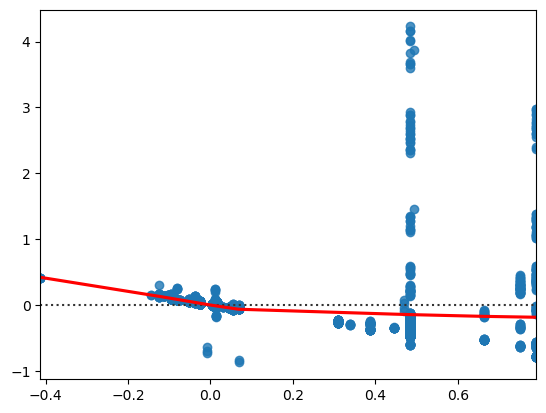

In [34]:
# Residuals on model 1 shows significiant nonlinear pattern and variation in residuals, meaning significant heteroscedasticity and non-linearity
sns.residplot(x=model1.fittedvalues, y=model1.resid, lowess=True, line_kws={"color":"red"})

<Axes: >

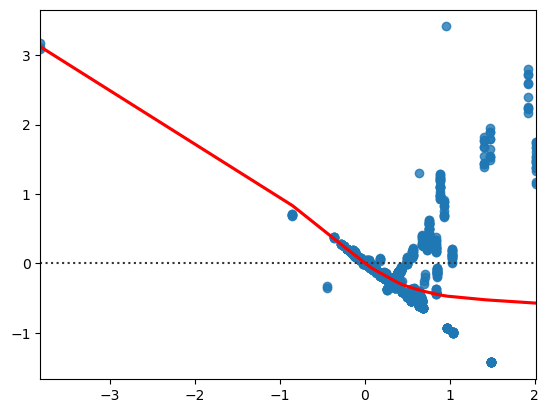

In [35]:
# Residuals on model 1  still shows significiant nonlinear pattern and variation in redicual, with slight improvment, but still holds the same issues
sns.residplot(x=model2.fittedvalues, y=model2.resid, lowess=True, line_kws={"color":"red"})

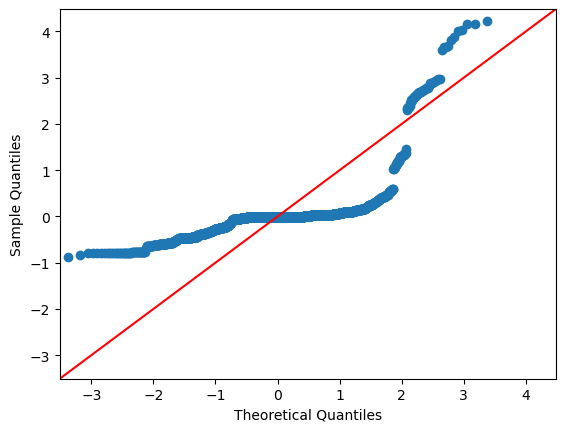

In [36]:
# Strong deviation from the red line indicates non-normal residuals
sm.qqplot(model1.resid, line= "45")
plt.show()

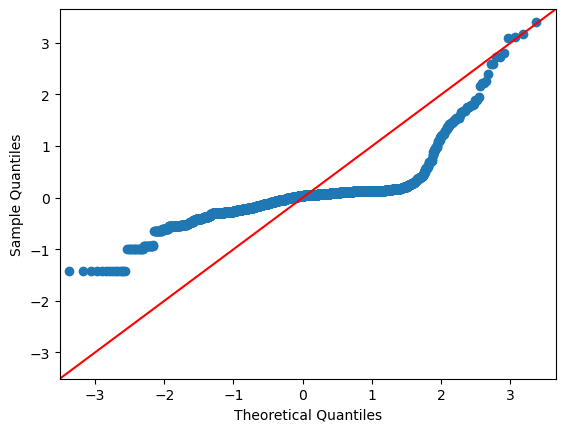

In [37]:
# Strong deviation from the red line indicates there is still non-normal residuals
sm.qqplot(model2.resid, line="45")
plt.show()

### Findings
Model Performance

    R-squared improved from 0.213 (model 1) to 0.475 (model 2).

    Adjusted R-squared increased from 0.183 to 0.453, which is a clear indication model 2 explains much more variance.

    F-statistic jumped from 7.19 to 22.00, with highly significant p-values, indiciating overall model fit improved.

    Model 2 added Amount as a predictor (very strong significance, p < 0.001).

Residual Diagnostics (from plots + output)

    Model 1: Severe non-linearity, heteroscedasticity, and non-normal residuals.

    Model 2: Improvement in overall fit but still strong violations:

    Residual vs. fitted plot showed a “V” shape indiciating possible overfitting or misspecification.

    Q-Q plot: residuals still deviate heavily from normality.

    Skewness and kurtosis remain very high (Skew ~3.2, Kurtosis ~18 for model 2).

Other Observations

    Both models show Durbin-Watson near 2, so autocorrelation is not a major concern.

    CompanyName and committmentcategory variables have strong, consistent significance.

    ReasonCode remains mostly non-significant in both models.


### Next Steps / Recommendations
#### Address model issues

Transformations or nonlinear modeling:

    The “V” shaped residual pattern suggests non-linearity; consider adding polynomial terms, interaction terms, or using splines.

Check multicollinearity: High condition number (5.94e+05) for model 2 suggests severe multicollinearity, likely due to Amount. Scale or transform Amount, or consider variance inflation factor (VIF) analysis.

Consider robust regression: To mitigate influence of outliers and heteroscedasticity.

Log-transform Amount: A log transformation of Amount (e.g., log(Amount)) might stabilize variance and reduce skewness.

Further modeling options
    
    Explore regularized regression (LASSO/Ridge) to help with multicollinearity and overfitting.

    If linear assumptions continue to fail, consider tree-based methods (e.g., Random Forest, XGBoost) which handle non-linearity and interactions naturally.

Reporting / Interpretation

    Clearly state that model 2 explains much more variance but still violates regression assumptions → interpret coefficients with caution.

    Emphasize the substantial effect and significance of Amount.

    Note that ReasonCode does not add meaningful explanatory power effectively.